In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import imodelsx.process_results
from collections import defaultdict
sys.path.append('../experiments/')
results_dir = '../results/multitask_gam/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/03_multitask_gam.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['r2_test'] = r['r2_test'].clip(-1, 1)
r['r2_gap'] = r['r2_train'] - r['r2_test']
# r.to_pickle('../results/agg.pkl')
# imodelsx.process_results.delete_runs_in_dataframe(r[r.use_bagging_ensemble == 1], actually_delete=True)
# imodelsx.process_results.get_experiment_keys(r, experiment_filename)

[2024-03-09 23:47:11,844] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/home/chansingh/imodelsx/.venv/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_bui

## Look at pred performance

In [3]:
d = r
d = imodelsx.process_results.average_over_seeds(
    d, experiment_filename, key_to_average_over='seed'
)
# filter datasets for which there is a row with use_multitask=0 and use_multitask=1 (done running)
d = d.groupby(['dataset_name'])
d = d.filter(lambda x: len(x) == 2)

In [4]:
# pivot table for d2 based on dataset_name, use_multitask, and r2_test
r2_table = d.pivot_table(index=['dataset_name'], columns=[
    'use_multitask'], values='r2_test')

# add num_features based on dataset_name
n_features = d.groupby(['dataset_name']).first().n_features
n_samples = d.groupby(['dataset_name']).first().n_samples
r2_table['num_features'] = n_features
r2_table['num_samples'] = n_samples
r2_table['feature_over_samples'] = r2_table['num_features'].astype(
    int) / r2_table['num_samples'].astype(int)
r2_table = r2_table.rename(columns={0: 'standard', 1: 'multitask'})

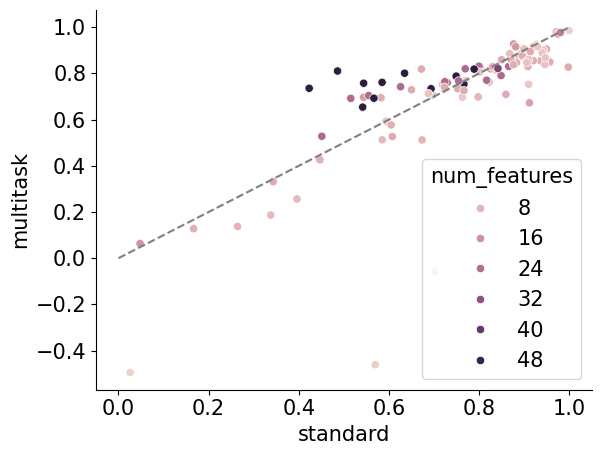

In [9]:
sns.scatterplot(data=r2_table, x='standard', y='multitask', hue='num_features')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.show()

### Analyze which features were kept